In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np

# 1. Load Data 
# Note: The sample you pasted looks space-separated. 
# If reading from a file, use sep='\s+' or sep='\t' depending on the actual file.
# Here we simulate loading your headers.
columns = [
"Year of occurrence",
"Month of occurrence",
"Date of occurrence",
"The occurrence time",
"Accident category name",
"The processing unit name is the police station layer.",
"Location of occurrence",
"Weather name",
"Ray name",
"Road category - 1st party - name",
"Speed limit - First party",
"Road type categories name",
"Road type subcategory name",
"Accident Location Major Category Name",
"Accident location subcategory name",
"Road Conditions - Road Pavement Names",
"Road Conditions - Road Condition Names",
"Road Conditions - Road Surface Defect Name",
"Road obstruction - obstacle name",
"Road obstruction-visual distance quality name",
"Obstacle on the road - visibility name",
"Traffic signal - traffic signal type name",
"Signal - Signal Action Name",
"Roadway Lane Division Facilities - Categories Name for Lane Division Facilities",
"Road Marking Facilities - Subcategory Names for Lane Division Facilities",
"Road division facilities - Lane separation facilities - Name between express lanes or general lanes",
"Road division facilities - lane division facilities - name of the lane between the fast and slow lanes",
"Roadway division facilities - Dividing facilities - Road surface sidelines names",
"Types and categories of accident types and forms",
"Accident type and type subcategory name",
"The cause is determined to be the major category name - main.",
"The main cause of research inference-child categories name 主要",
"The number of deaths and injuries",
"Party Ranking",
"Party division - category - major category name - type of vehicle",
"Party Category Subcategory Name Vehicle Type",
"Party's gender identity",
"The age of the party at the time of the accident occurred",
"Protective equipment name",
"Mobile phone or computer or other similar functional device name",
"The name of the party's action state category",
"Party Action Status Subcategory Name",
"Vehicle impact site major category name - initial",
"Vehicle Collision Point Category Name - Initial",
"Vehicle collision location category name - Other",
"Vehicle impact area subcategory name - other",
"The cause is judged as a major category name - individual.",
"The cause is judged to be the category name - individual.",
"Hit and run category name - Are you a hit and run",
"Longitude",
"Latitude"
]

In [2]:
important_categories = [
# "Year of occurrence",
# "Month of occurrence",
# "Date of occurrence",
"The occurrence time",
# "Accident category name",
# "The processing unit name is the police station layer.",
"Location of occurrence",
"Weather name",
# "Ray name",
# "Road category - 1st party - name",
"Speed limit - First party",
"Road type categories name",
"Road type subcategory name",
"Accident Location Major Category Name",
"Accident location subcategory name",
"Road Conditions - Road Pavement Names",
"Road Conditions - Road Condition Names",
"Road Conditions - Road Surface Defect Name",
"Road obstruction - obstacle name",
"Road obstruction-visual distance quality name",
"Obstacle on the road - visibility name",
"Traffic signal - traffic signal type name",
# "Signal - Signal Action Name",
"Roadway Lane Division Facilities - Categories Name for Lane Division Facilities",
"Road Marking Facilities - Subcategory Names for Lane Division Facilities",
# "Road division facilities - Lane separation facilities - Name between express lanes or general lanes",
# "Road division facilities - lane division facilities - name of the lane between the fast and slow lanes",
# "Roadway division facilities - Dividing facilities - Road surface sidelines names",
"Types and categories of accident types and forms",
"Accident type and type subcategory name",
# "The cause is determined to be the major category name - main.",
# "The main cause of research inference-child categories name 主要",
"The number of deaths and injuries",
# "Party Ranking",
"Party division - category - major category name - type of vehicle",
# "Party Category Subcategory Name Vehicle Type",
"Party's gender identity",
"The age of the party at the time of the accident occurred",
# "Protective equipment name",
# "Mobile phone or computer or other similar functional device name",
# "The name of the party's action state category",
# "Party Action Status Subcategory Name",
# "Vehicle impact site major category name - initial",
# "Vehicle Collision Point Category Name - Initial",
# "Vehicle collision location category name - Other",
# "Vehicle impact area subcategory name - other",
# "The cause is judged as a major category name - individual.",
# "The cause is judged to be the category name - individual.",
"Hit and run category name - Are you a hit and run",
"Longitude",
"Latitude"
]

important_categories = columns

In [3]:
# combining all csv files into all.csv
import os
import zipfile

all_data = pd.DataFrame()

if not os.path.exists('datasets/latest/csvs/all.csv'):
    os.makedirs('datasets/latest/csvs/', exist_ok=True)

    # extract zip files
    for file in os.listdir('datasets/latest/'):
        if file.endswith('.zip'):
            with zipfile.ZipFile(os.path.join('datasets/latest/', file), 'r') as zip_ref:
                zip_ref.extractall('datasets/latest/csvs/')

    # remove all files files that are not NPA_TMA2*.csv
    for file in os.listdir('datasets/latest/csvs/'):
        
        # remove irrelevant files
        if not file.startswith('NPA_TMA2') or not file.endswith('.csv'):
            os.remove(os.path.join('datasets/latest/csvs/', file))
        
        # concatenate all relevant csv files into one
        else:
            df = pd.read_csv(os.path.join('datasets/latest/csvs/', file), dtype=str, sep=',')
            all_data = pd.concat([all_data, df.iloc[ int(df.empty) :-2, :]], ignore_index=True)
    
    all_data.to_csv('datasets/latest/csvs/all.csv', index=False)
    print("Combined all CSV files into all.csv")

print("Loading all.csv...")
all_data = all_data if not all_data.empty else pd.read_csv('datasets/latest/csvs/all.csv', dtype=str, sep=',')
print("done.")

print(f"Total records: {len(all_data)}")
print(f'Total columns: {len(all_data.head().columns)}')

Loading all.csv...
done.
Total records: 722633
Total columns: 51


In [4]:
all_data.columns = columns
columns = important_categories
all_data = all_data[ important_categories ]

### Filtering accidents only within taiwan for clustering visualization

In [5]:
# (緯度, 經度) = (Latitude, Longitude)

# main island of taiwan coordinates:
    # east, west:
    # (23.595973, 122.703662), (24.003341, 118.765822)

    # north, south:
    # (25.562329, 121.213983), (21.361464, 120.677724)

coor_data = all_data.copy()

# filter coordinates to be within main island of taiwan 

print('total before filter cooridinates:', len(all_data))
coor_data['Latitude'] = pd.to_numeric(coor_data['Latitude'], errors='coerce')
coor_data['Longitude'] = pd.to_numeric(coor_data['Longitude'], errors='coerce')
coor_data = coor_data[(coor_data['Longitude'] >  118.765822) & (coor_data['Longitude'] < 122.703662)]
coor_data = coor_data[(coor_data['Latitude'] > 21.361464) & (coor_data['Latitude'] < 25.562329)]

# copy filtered data to all_data
all_data = coor_data.copy()

print('total after filter cooridinates:', len(coor_data))


# save coordinates in js format for clustering in leaflet map
y = coor_data['Longitude'].to_numpy()
x = coor_data['Latitude'].to_numpy()

coordinates = [ [xval, yval, ] for xval, yval in zip(x, y)]

with open("map/coordinates.js", "w") as file:
    file.write("coordinates = [")
    for coordinate in coordinates:
        file.write(f"[{coordinate[0]}, {coordinate[1]}],\n")
    
    file.write("\n];")
print("Saved coordinates to map/coordinates.js")

del coor_data

total before filter cooridinates: 722633
total after filter cooridinates: 720393
Saved coordinates to map/coordinates.js


In [6]:
df = all_data.replace(['na',], np.nan, inplace=False)
print('total rows with NAN:', len(df))
df =all_data.dropna(inplace=False)
print('total rows without NAN:', len(df))

total rows with NAN: 720393
total rows without NAN: 59246


In [7]:
df_encoded = all_data.copy()
df_encoded.columns = columns

# filter party ranking to 1 (main party of accident)
# df_encoded = df_encoded[df_encoded['Party Ranking'] == '1']

print(f"Total records: {len(df_encoded)}")
print(f'Total columns: {len(df_encoded.head().columns)}')

Total records: 720393
Total columns: 51


In [8]:
# 3. Data Inspection (Correlation Hint)
# We need to convert non-numeric columns to numeric codes to see correlation
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes


# Now remove rows where any column has the value -1 (which represents NaN after encoding)
df_encoded = df_encoded[df_encoded.ne(-1).all(axis=1)]

/home/sam/Documents/bdFinal/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/sam/Documents/bdFinal/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/sam/Documents/bdFinal/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sam/Documents/bdFinal/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


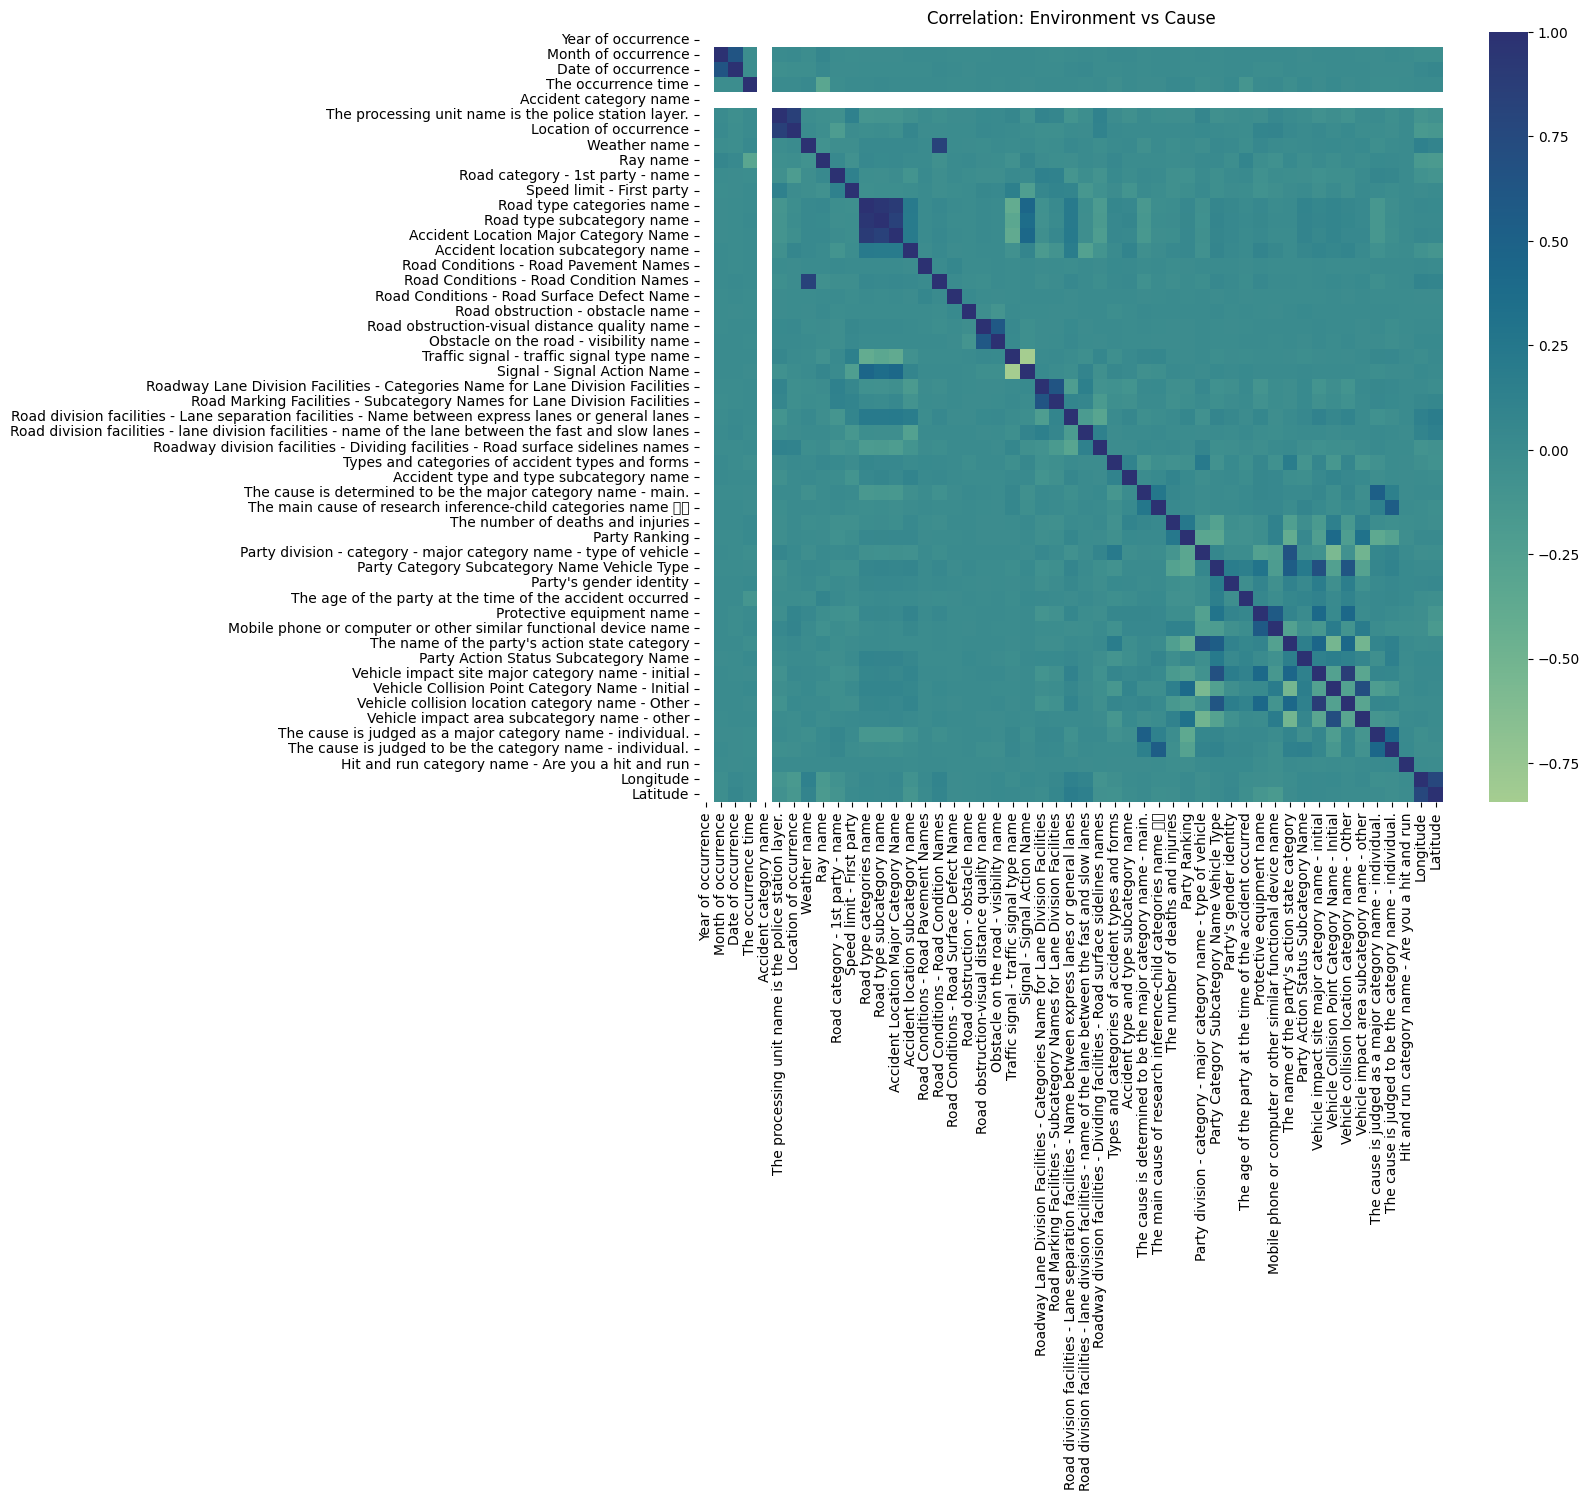

In [9]:
# 4. Generate Heatmap
plt.figure(figsize=(12, 10)) 
correlation = df_encoded[
    columns
].corr()
sns.heatmap(correlation, annot=False, cmap='crest')
plt.title("Correlation: Environment vs Cause")
plt.show()

In [10]:
correlation["Hit and run category name - Are you a hit and run"]

Year of occurrence                                                                                             NaN
Month of occurrence                                                                                      -0.006779
Date of occurrence                                                                                       -0.009444
The occurrence time                                                                                      -0.001952
Accident category name                                                                                         NaN
The processing unit name is the police station layer.                                                     0.009307
Location of occurrence                                                                                    0.002776
Weather name                                                                                              0.001615
Ray name                                                                        

/home/sam/Documents/bdFinal/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sam/Documents/bdFinal/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


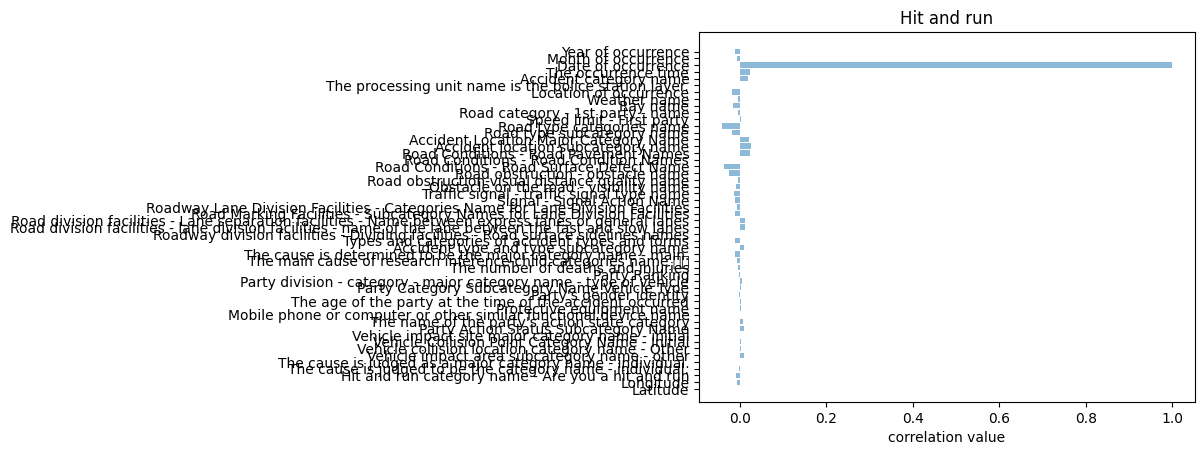

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

labels = columns
values = correlation["Hit and run category name - Are you a hit and run"].to_numpy()

objects = labels
objects.reverse()
# objects = objects[3:-10]
y_pos = np.arange(len(objects))
performance = values

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('correlation value')
plt.title('Hit and run')

plt.show()

### Split data into train and test sets

In [12]:
from sklearn.model_selection import train_test_split

target = "Hit and run category name - Are you a hit and run"

X = df_encoded.drop(columns=[target])
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # important if data is imbalanced
)
